In [1]:
import astropy.units as u

from fleck import generate_spots
import numpy as np

from altaipony.altai import aflare
import matplotlib.pyplot as plt

from altaipony.utils import generate_random_power_law_distribution

def indep_roll(arr, shifts, axis=1):
    """Apply an independent roll for each dimensions of a single axis.

    Parameters
    ----------
    arr : np.ndarray
        Array of any shape.

    shifts : np.ndarray
        How many shifting to use for each dimension. Shape: `(arr.shape[axis],)`.

    axis : int
        Axis along which elements are shifted. 
    """
    arr = np.swapaxes(arr,axis,-1)
    all_idcs = np.ogrid[[slice(0,n) for n in arr.shape]]

    # Convert to a positive shift
    shifts[shifts < 0] += arr.shape[-1] 
    all_idcs[-1] = all_idcs[-1] - shifts[:, np.newaxis]

    result = arr[tuple(all_idcs)]
    arr = np.swapaxes(result,-1,axis)
    return arr

def generate_lc(t, alpha, beta, emin, emax):
    # select FFD parameters in ED space

    LC = np.zeros(t.shape)
#     print(LC.shape)
    for i, dt in enumerate(t):
        EDs = generate_random_power_law_distribution(emin[i], emax[i], alpha[i]+1, beta[i])
        lc = (np.array([aflare(dt, np.random.rand()*2*np.pi, .02, ed) for ed in EDs]).sum(axis=0) + 1.)
#         print(dt.shape, lc.shape, i, beta[i])
        LC[i,:] = lc.reshape(dt.shape)
    
    return np.array(LC)

In [2]:
t = np.arange(0, 2 * np.pi, 2 * np.pi/600) 

In [3]:

flares = generate_lc(t.reshape(1,len(t)), [-1.6], [10], [1], [100])

In [4]:
flares.shape

(1, 600)

In [17]:
u_ld = [0.5079, 0.2239]

n_phases = 1
phases = t * u.rad
n_inclinations = 10
n_spots = 1


dt =  np.repeat(np.array([t]), repeats=n_spots, axis=0)
flares = generate_lc(dt, [-1.6], [100], [1], [100])

In [18]:
flares.shape

(1, 600)

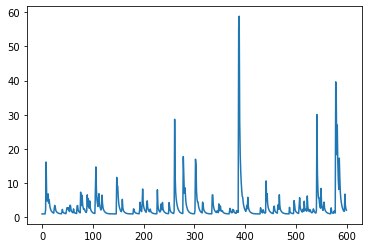

In [19]:
plt.plot(flares.T);

In [20]:
nspotnincflare = np.repeat(flares.T[:,:,np.newaxis], 
                           repeats=n_inclinations, axis=2)
nspotnincflare.shape

(600, 1, 10)

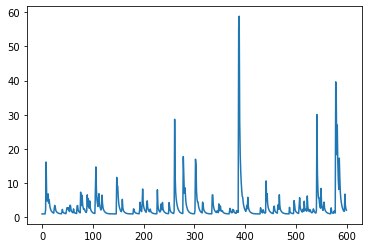

In [21]:
plt.plot(nspotnincflare[:,:,0]);

In [51]:
spot_radius = 0.01   # Rspot/Rstar
min_latitude = 70  # deg
max_latitude = 80   # deg

lons, lats, radii, inc_stellar = generate_spots(min_latitude, max_latitude,
                                                spot_radius, n_spots,
                                                n_inclinations=n_inclinations)



In [52]:
lons, lats

(<Quantity [[102.14490173,  60.00809735, 181.95244545, 129.21380313,
              44.51628019, 237.90740305,  57.23209122, 118.19014267,
             199.67873339,  20.29424442]] deg>,
 <Quantity [[78.3566309 , 73.95573422, 72.85017402, 70.15795534,
             75.15297042, 76.08383553, 75.71940726, 75.84755475,
             73.93303314, 74.65567095]] deg>)

In [53]:
from fleck import Star

star = Star(spot_contrast=nspotnincflare, phases=phases, u_ld=u_ld, n_phases=1)

In [54]:
plt.figure(figsize=(15,5))
lcs = star.light_curve(lons, lats, radii, inc_stellar)

<Figure size 1080x360 with 0 Axes>

In [55]:
lcs.shape

(600, 10)

In [56]:
star.phases

<Quantity [0.        , 0.01047198, 0.02094395, 0.03141593, 0.0418879 ,
           0.05235988, 0.06283185, 0.07330383, 0.0837758 , 0.09424778,
           0.10471976, 0.11519173, 0.12566371, 0.13613568, 0.14660766,
           0.15707963, 0.16755161, 0.17802358, 0.18849556, 0.19896753,
           0.20943951, 0.21991149, 0.23038346, 0.24085544, 0.25132741,
           0.26179939, 0.27227136, 0.28274334, 0.29321531, 0.30368729,
           0.31415927, 0.32463124, 0.33510322, 0.34557519, 0.35604717,
           0.36651914, 0.37699112, 0.38746309, 0.39793507, 0.40840704,
           0.41887902, 0.429351  , 0.43982297, 0.45029495, 0.46076692,
           0.4712389 , 0.48171087, 0.49218285, 0.50265482, 0.5131268 ,
           0.52359878, 0.53407075, 0.54454273, 0.5550147 , 0.56548668,
           0.57595865, 0.58643063, 0.5969026 , 0.60737458, 0.61784656,
           0.62831853, 0.63879051, 0.64926248, 0.65973446, 0.67020643,
           0.68067841, 0.69115038, 0.70162236, 0.71209433, 0.72256631,
      

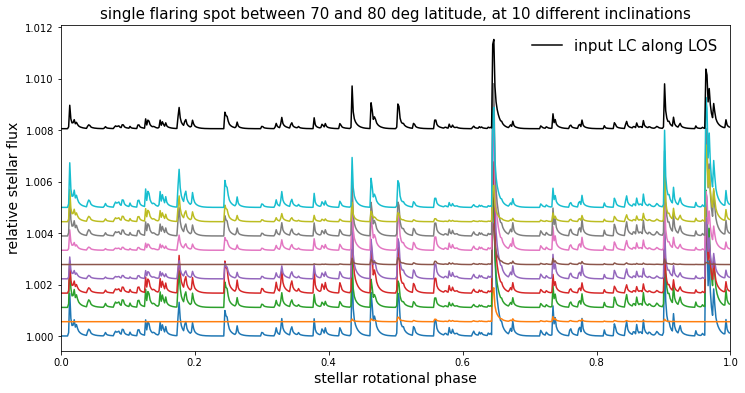

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(star.phases/2/np.pi, lcs[:,:]+np.linspace(0,5e-3,lcs.shape[1]))
plt.plot(star.phases/2/np.pi, nspotnincflare[:,:,0]*6e-5 +1.008, c="k",label="input LC along LOS");
plt.xlim(0,1)
plt.xlabel("stellar rotational phase", fontsize=14)
plt.ylabel("relative stellar flux", fontsize=14)
plt.legend(fontsize=15, loc=1, frameon=False);
# plt.yscale("log")
plt.title("single flaring spot between 70 and 80 deg latitude, at 10 different inclinations", fontsize=15)
plt.savefig("plots/2021_12_07_single_flaring_spot_distribution_70_80.png", dpi=300);